# Blackpropagation in Neural Networks

In [1]:
using Distributions
using LinearAlgebra
using Plots

In [2]:
function Linear(x, alpha=1.)
    #=-----------------------------------------------
    Linear function.
    -------------------------------------------------
    Arguments:
        x    :   Input
        alpha:   Scaling factor. Default value is 1.
    -------------------------------------------------
    Returns the value of the function and its 
    derivative as a tuple.
    -----------------------------------------------=#
    return (alpha*x, alpha)
end;

function Tanh(x)
    #=-----------------------------------------------
    Hyperbolic tangent function.
    -------------------------------------------------
    Arguments:
        x    :   Input
    -------------------------------------------------
    Returns the value of the function and its 
    derivative as a tuple.
    -----------------------------------------------=#
    z = tanh(x)
    dz = sech(x)^2
    return (z, dz)
end;

function Logistic(x, alpha = 1.)
    #=-----------------------------------------------
    Logistic Function
    -------------------------------------------------
    Arguments:
        x    :   Input
        alpha:   the logistic growth rate. Default 
                 value is 1.
    -------------------------------------------------
    Returns the value of the function and its 
    derivative as a tuple.
    -----------------------------------------------=#
    z = 1.0 / (1.0 + exp(-alpha*x))
    dz = alpha*exp(-alpha*x)*z^2
    return (z, dz)
end;

function ReLU(x)
    #=-----------------------------------------------
    Rectified linear unit function (ReLU)
    -------------------------------------------------
    Arguments:
        x    :   Input
    -------------------------------------------------
    Returns the value of the function and its 
    derivative as a tuple.
    -----------------------------------------------=#
    z = (x > 0.)*x
    dz = 1. *(x > 0.)
    return (z, dz)
end;

In [3]:
function forward_step(y, w, b, f_act)
    #=-----------------------------------------------
    Calculate values in next layer.
    -------------------------------------------------
    Arguments:
        y    :   Input
        w    :   Weights
        b    :   Bias
        f_act:   Activation function ( Nonlinearity).
                 f_act return (f(z), f'(z))
                 Default value is logistic function.
    -----------------------------------------------=#
    z = y*w .+ transpose(b)
    return (f_act.(z))
end;

In [4]:
function apply_net(y_in, Weights, Biases, Numlayers, y_layer, df_layer, f_act)
    #=-----------------------------------------------
    One forward pass through the network
    -------------------------------------------------
    Arguments:
        y_in   :   Inputs
        f_act  :   Activation function.
                   Default value is logistic function.
        Weights:   Weights of conections amoung neurals.
        Biases :   Array of biases for layers.
        Numlayers: Number of layers.
        y_layer:   Array for storing y-values.
        df_layer:  Array for storing df/dz values
    -----------------------------------------------=#
    y = y_in # start with input values
    y_layer[1] = y
    for j in 1:NumLayers # loop through all layers
        # j=1 corresponds to the first layer above the input
        F = forward_step(y, Weights[j], Biases[j], f_act) # one step
        y, df= first.(F), last.(F)
        df_layer[j] = df # store f'(z) [needed later in backprop]
        y_layer[j+1] = y # store f(z) [also needed in backprop]
    end
    return(y)
end;

In [5]:
function apply_net_simple(y_in, Weights, Biases, Numlayers, y_layer, df_layer, f_act)
    #=-----------------------------------------------
    One forward pass through the network
    -------------------------------------------------
    Arguments:
        y_in   :   Inputs
        f_act  :   Activation function.
                   Default value is logistic function.
        Weights:   Weights of conections amoung neurals.
        Biases :   Array of biases for layers.
        Numlayers: Number of layers.
        y_layer:   Array for storing y-values.
        df_layer:  Array for storing df/dz values
    -----------------------------------------------=#
    y = y_in # start with input values
    y_layer[1] = y
    for j in 1:NumLayers # loop through all layers
        # j=1 corresponds to the first layer above the input
        F = forward_step(y, Weights[j], Biases[j], f_act) # one step
        y, df= first.(F), last.(F)
        y_layer[j+1] = y # store f(z) [also needed in backprop]
    end
    return(y)
end;

In [6]:
function backward_step(delta,w,df)
    #=----------------------------------------------
    Take step from ‘layer’ down to ‘lower layer’.
    ------------------------------------------------
    Argument:
        delta:   delta at layer N
                 Size:  [batchsize x layersize(N))]
        w    :   Weights between N-1 and N layers.
                 Size: [layersize(N-1) x layersize(N)]
        df   :   df/dz at layer N-1.
                 Size: batchsize x layersize(N-1)
    ----------------------------------------------=#
    return((delta*transpose(w)).*df)
end;

In [7]:
function backprop(y_target, Weights, Biases, NumLayers, y_layer, df_layer, dw_layer, db_layer, batchsize)
    #=--------------------------------------------
    One backward pass through the network.
    The result will be the 'dw_layer' matrices that 
    contain the derivatives of the cost function 
    with respect to the corresponding weight.
    ------------------------------------------------
    Argument:
        y_target
    ----------------------------------------------=#    
    # Output error
    delta = (y_layer[end]-y_target).*df_layer[end]
    dw_layer[end]=transpose(y_layer[end-1])*delta/batchsize
    db_layer[end]=[sum(delta)/batchsize]
    for j in 0:NumLayers-2
        delta = [backward_step(delta,Weights[end-j],df_layer[end-1-j])]
        dw_layer[end-1-j] = transpose(y_layer[end-2-j])*delta[1]/batchsize
        db_layer[end-1-j] = vec(sum(delta[1], dims=1)/batchsize)
        delta = delta[1]
    end
end;

In [8]:
function gradient_step(eta, Weights, Biases, NumLayers, dw_layer, db_layer)
    #=----------------------------------------------
    Update weights & biases after backpropagation.
    ----------------------------------------------=#    
    for j in 1:NumLayers
        #print(size(Weights[j]),size(dw_layer[j]))
        Weights[j] -= eta[1]*dw_layer[j]
        #print(j)
        Biases[j] -= eta[2]*db_layer[j]
    end
end;

In [9]:
function train_net(y_in, y_target, eta, Weights, Biases, NumLayers, y_layer, df_layer, f_act)
    #=----------------------------------------------
    One full training batch.
    ------------------------------------------------
    Arguments:
        y_in   :    Array of size:
                    batchsize x (input-layer-size)
        y_target:   Array of size:
                    batchsize x (output-layer-size)
        eta    :    Stepsize for the gradient descent.
    ----------------------------------------------=#
    y_out_result=apply_net(y_in, Weights, Biases, NumLayers, y_layer, df_layer, f_act)
    backprop(y_target, Weights, Biases, NumLayers, y_layer, df_layer, dw_layer, db_layer, batchsize)
    gradient_step(eta, Weights, Biases, NumLayers, dw_layer, db_layer)
    cost=sum((y_out_result-y_target).^2)/batchsize
    return(cost)
end;

In [10]:
NumLayers = 2 # does not count input-layer (but does count output)
LayerSizes = [2,100,1] # input-layer,hidden-1,hidden-2,...,output-layer

# initialize random weights and biases for all layers (except input of course)
Weights=[rand(Uniform(-0.1,0.1), LayerSizes[j], LayerSizes[j+1]) for j in 1:NumLayers]
Biases=[zeros(LayerSizes[j+1]) for j in 1:NumLayers]

# define the batchsize
batchsize=100
f_act = ReLU;

In [11]:
# set up all the helper variables

y_layer=[zeros(batchsize,LayerSizes[j]) for j in 1:(NumLayers+1)]
df_layer=[zeros(batchsize,LayerSizes[j+1]) for j in 1:NumLayers]
dw_layer=[zeros(LayerSizes[j],LayerSizes[j+1]) for j in 1:NumLayers]
db_layer=[zeros(LayerSizes[j+1]) for j in 1:NumLayers];

In [12]:
function Func2D(x0,x1)
    r2 = x0^2 + x1^2
    return(exp(-5*r2)*abs(x1+x0))
end;

In [13]:
meshgrid(xs, ys) = [xs[i] for i in 1:length(xs), j in length(ys)], [ys[j] for i in 1:length(xs), j in 1:length(ys)]
xrange = range(-0.5, 0.5, 40);

In [14]:
Z = [Func2D(x, y) for x in xrange, y in xrange];

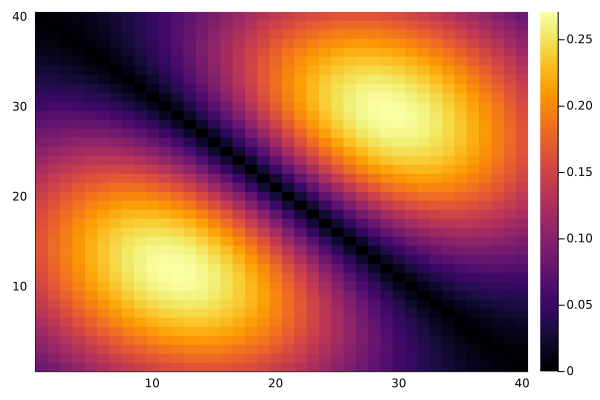

In [15]:
heatmap(Z)

In [16]:
test_batchsize = size(Z)[1]*size(Z)[2]
testsample = zeros(test_batchsize,2)
for ii in 0:test_batchsize-1
    testsample[ii+1,1] = xrange[ii%(size(xrange)[1])+1]
    testsample[ii+1,2] = xrange[div(ii,(size(xrange)[1]))+1]
end;

In [17]:
testoutput = apply_net_simple(testsample, Weights, Biases, NumLayers, y_layer, df_layer, f_act);

In [18]:
ZZ = reshape(testoutput, size(Z));

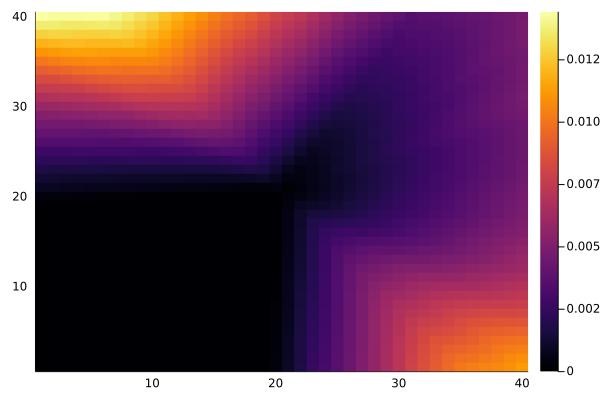

In [19]:
myim = heatmap(ZZ)

In [20]:
function make_batch(batchsize, f)
    inputs = rand(Uniform(-0.5,0.5), batchsize, 2)
    targets = zeros(batchsize,1) # must have right dimensions
    targets[:, 1] = f.(inputs[:,1],inputs[:,2])
    return(inputs,targets)
end;

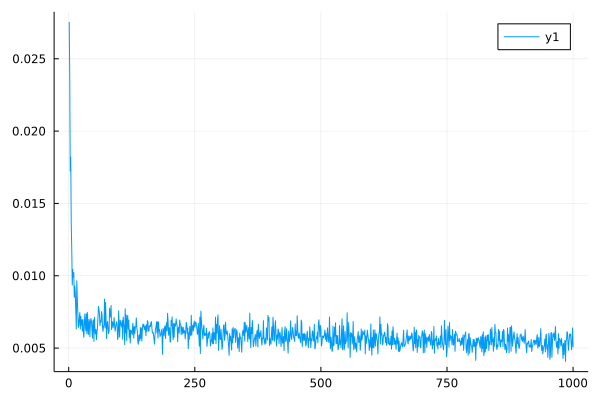

In [21]:
eta = [0.001, 0.1]
batches = 1000
costs = zeros(batches) # array to store the costs

for k in 1:batches
    y_in , y_target = make_batch(batchsize, Func2D)
    costs[k]=train_net(y_in, y_target, eta, Weights, Biases, NumLayers, y_layer, df_layer, f_act)
end;

plot(costs)

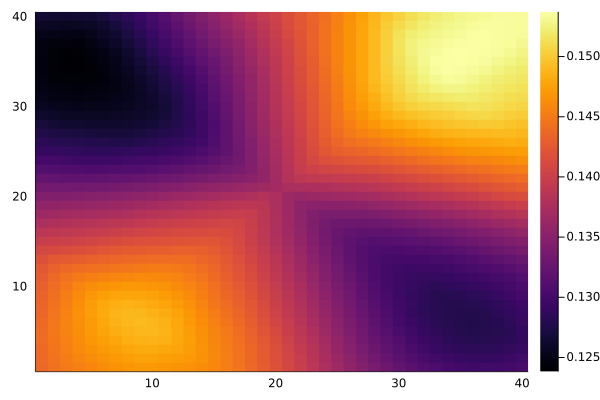

In [22]:
testoutput = apply_net_simple(testsample, Weights, Biases, NumLayers, y_layer, df_layer, f_act); # check the new network output in the plane 
heatmap(reshape(testoutput, size(Z)))

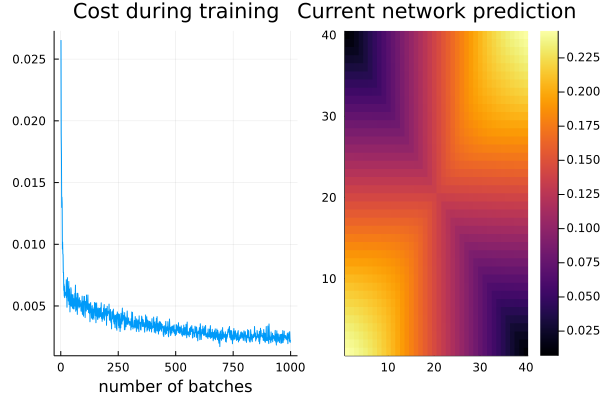

In [23]:
NumLayers = 2 # does not count input-layer (but does count output)
LayerSizes = [2,100,1] # input-layer,hidden-1,hidden-2,...,output-layer

# initialize random weights and biases for all layers (except input of course)
Weights=[rand(Uniform(-0.1,0.1), LayerSizes[j], LayerSizes[j+1]) for j in 1:NumLayers]
Biases=[zeros(LayerSizes[j+1]) for j in 1:NumLayers]

# define the batchsize
batchsize=100
f_act = ReLU;

# set up all the helper variables

y_layer=[zeros(batchsize,LayerSizes[j]) for j in 1:(NumLayers+1)]
df_layer=[zeros(batchsize,LayerSizes[j+1]) for j in 1:NumLayers]
dw_layer=[zeros(LayerSizes[j],LayerSizes[j+1]) for j in 1:NumLayers]
db_layer=[zeros(LayerSizes[j+1]) for j in 1:NumLayers];


eta = [0.25, 0.1]
batches = 1000
costs = zeros(batches) # array to store the costs

for k in 1:batches
    y_in , y_target = make_batch(batchsize, Func2D)
    costs[k]=train_net(y_in, y_target, eta, Weights, Biases, NumLayers, y_layer, df_layer, f_act)
    testoutput = apply_net_simple(testsample, Weights, Biases, NumLayers, y_layer, df_layer, f_act); # check the new network output in the plane 
    if k%10 == 0
        IJulia.clear_output(true)
        p2 = heatmap(reshape(testoutput, size(Z)), title="Current network prediction")
        p1 = plot(costs, xlabel ="number of batches", title= "Cost during training")
        display(plot!(p1, p2, layout = (1, 2), legend = false))
    end
    #sleep(0.2)
end;